本章开头，我们将介绍两种可以改进模型泛化的方法，即图像增广和微调，并将它们应用于图像分类。由于深度神经网络可以有效地表示多个层次的图像，因此这种分层已经成功应用于各种计算机视觉任务。

大型数据集是成功应用深度神经网络的先决条件。图像增广在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模。此外，应用图像增广的原因是，随机改变训练样本可以减少模型对某些属性的依赖，从而提高模型的泛化能力。例如，我们可以以不同的方式裁剪图像，使感兴趣的对象出现在不同的位置，减少模型对于对象出现位置的依赖。还可以通过调整亮度、颜色等因素来降低模型对于颜色的敏感度。 

# 1. 常用的图像增广方法

在对常用图像增广方法的探索时，我们将使用下面这个尺寸为400x500的图像作为示例。

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

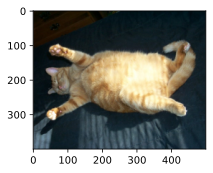

In [3]:
d2l.set_figsize()
img = d2l.Image.open('./cat1.jpg')
d2l.plt.imshow(img);

大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数apply。此函数在输入图像img上多次运行增广方法aug并显示所有结果。

In [4]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

## 1.1 翻转和裁剪

左右翻转图像通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。接下来，我们使用transforms模块来创建RandomFlipLeftRight实例，这样就各有50%的几率使图像向左或向右翻转。

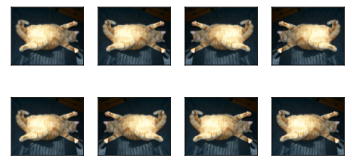

In [5]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

上下翻转图像不如左右翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。接下来，我们创建一个RandomFlopBottom实例。

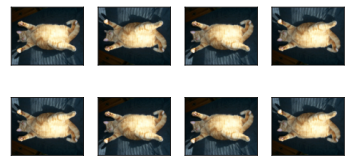

In [6]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在我们使用的示例图像中，猫位图图像中间，但并非所有图像都是这样。之前，我们解释了汇聚层可以降低卷积层对目标位置的敏感性。另外，我们可以通过对图像进行随机裁剪，使物体不同的比例出现在图像的不同位置。这也可以降低模型对目标位置的敏感性。

下面的代码将随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5~2之间随机取值。然后，区域的宽度和高度都被缩放到200像素。在本节中，a和b之间的随机数指的是在区间[a,b]中通过均匀采样获得的连续值。

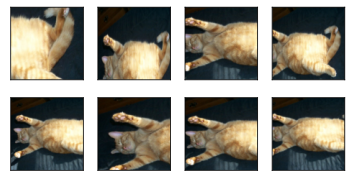

In [7]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200,200), scale=(0.1,1), ratio=(0.5,2))
apply(img, shape_aug)

## 1.2 改变颜色

另一种增广方法是改变颜色。我们改变图像颜色的四个方面：亮度、对比度、饱和度和色调。在下面的示例中，我们随机改变图像的亮度，随机值为原始图像的50%（1-0.5）到150%(1+0.5)之间。

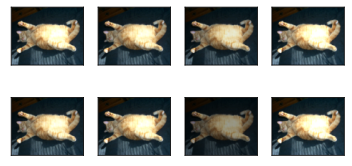

In [8]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0,saturation=0,hue=0))

同样我们可以随机更改图像的色调。

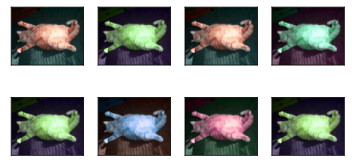

In [9]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0,contrast=0, saturation=0,hue=0.5))

我们还可以创建一个RandomColorJitter实例，并设置如何同时随机更改图像的亮度，对比度，饱和度和色调。

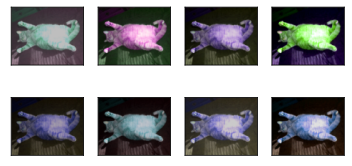

In [10]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

## 1.3 结合多种图像增广方法

在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个Compose实例来综合上面定义的不同的图像增广反复噶，并将它们应用到每个图像。

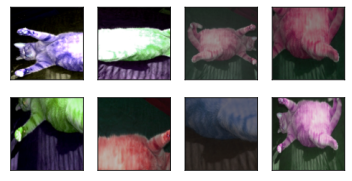

In [11]:
aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug,shape_aug
])
apply(img,aug)

# 2. 使用图像增广进行训练

使用CIFAR-10数据集，因为数据集中的对象的颜色和大小差异更明显。

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


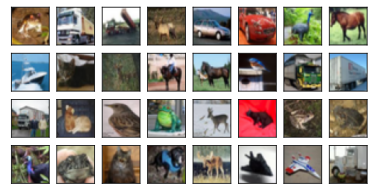

In [12]:
all_images = torchvision.datasets.CIFAR10(train=True,root="./",download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，并在预测过程中不使用随机操作的图像增广。在这里，我们只使用最简单的随机左右翻转。此外，我们使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，及形状为（批量大小、通道数、高度、了宽度）的32位浮点数，取值范围为0~1。

In [13]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

接下来，我们定义一个辅助函数，以便于读取图像和应用图像增广。PyTorch数据集提供的transform参数来应用图像增广来转换图像。

In [14]:
def load_cifar10(is_train,augs,batch_size):
    dataset = torchvision.datasets.CIFAR10(root="./",train=is_train,
                                          transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

## 2.1 多GPU训练

In [15]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

现在，我们可以定义train_with_data_aug函数，使用图像增广来训练模型。该函数获取所有的GPU，并使用Adam作为训练的优化算法，将图像增广用于训练集。最后调用刚刚定义的用于训练和评估模型的train_ch13函数。

In [16]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

让我们使用基于随机左右翻转的图像增广来训练模型。

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

Files already downloaded and verified
Files already downloaded and verified


# 3. 小结

- 图像增广基于现有的训练数据生成随机图像，来提高模型的泛化能力。
- 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，而在预测过程中不使用带随机操作的图像增广。
- 深度学习框架提供了许多不同的图像增广方法，这些方法可以被同时应用。